In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# Pandas for managing datasets
import pandas as pd
import numpy as np

# Matplotlib for additional customization
from matplotlib import pyplot as plt
%matplotlib inline
# Seaborn for plotting and styling
import seaborn as sns
from rdp import rdp
from datetime import datetime
from tools.data_extraction import DataExtractor
from tools.trajectory_generator import TrajectoryGenerator
from tools.utils import scale_down,standardize_data, print_genetic_param, print_settings, set_movements, angle_diff
train_test_options = {"split": 25}

In [2]:
ship =  pd.read_csv("ships/SIEM PILOT.csv")
shipname = ship.loc[0]["SHIPNAME"]
ship = ship [["TIMESTAMP","LAT","LON","HEADING"]]
ship['TIMESTAMP'] = pd.to_datetime(ship['TIMESTAMP'])  
ship.sort_values('TIMESTAMP',inplace=True)
ship=ship.reset_index(drop=True)
n = 500  #chunk row size
ship_dfs = [ship[i:i+n] for i in range(0,ship.shape[0],n)]
ship_data_chunked = []
for idx,x in enumerate(ship_dfs):
    x = scale_down(x,train_test_options["split"])
    x = np.array(x["HEADING"].values.astype(int))
    if len(x) == train_test_options["split"]:
        ship_data_chunked.append(x)
selected_trajectories = [False for i in range(0,len(ship_dfs))]
for j,i in enumerate(ship_dfs):
    if j in [1,2,3,4,5]:
        selected_trajectories[j] = True
ship_dfs = [ship for (ship,index) in zip(ship_dfs,selected_trajectories) if  index ]
ship_data_chunked = np.array([ship for (ship,index) in zip(ship_data_chunked,selected_trajectories) if  index ])
ship ={"shipname":shipname,"data":ship_data_chunked,"ship_dfs":ship_dfs}


In [3]:
def plot_trajectory(data,split,chunk_no,shipname,scaled_down=True,rdp_data=None):
    df_list = []
    data_list = []
    real_data=data.assign(Trajectory="Real Trajectory")
    df_list.append(real_data)
    data_list.append(real_data["Trajectory"].iloc[0])
    pallete = ['r']
    sizes = [6]
    dashes = [(5,5)]
    markers = ["^"]
    
    if scaled_down:         
        data_scaled=scale_down(data,split).assign(Trajectory="Scaled Trajectory")
        if len(data_scaled) == split:
            df_list.append(data_scaled)
            data_list.append(data_scaled["Trajectory"].iloc[0])
            pallete.append('b')
            sizes.append(3)
            dashes.append("")
            markers.append("o")

    
    if rdp_data is not None and type(rdp_data) == type(pd.DataFrame()) and len(rdp_data)>0:
        rdp_data=data.assign(Trajectory="RDP Trajectory")
        df_list.append(rdp_data)
        data_list.append(rdp_data["Trajectory"].iloc[0])
        pallete.append('g')
        sizes.append(1)
        dashes.append((5, 10))
        markers.append("o")

    merged_data = pd.concat(df_list)

    fig, ax= plt.subplots(1, 1, figsize=(30, 20),sharex=True)    
    start = datetime.strftime(data["TIMESTAMP"].head(1).iloc[0],'%Y-%m-%d %H:%M:%S')
    end = datetime.strftime(data["TIMESTAMP"].tail(1).iloc[0],'%Y-%m-%d %H:%M:%S')
    title = "Vessel:"+shipname+"\nCHUNK NO: "+str(chunk_no)+"\n"+start+"----"+end
    ax.set_title(title,fontsize=20)
    sns.lineplot(x='LON', y='LAT',
                      data=merged_data,
                      ax=ax,
                      sort=False,
                      hue = "Trajectory",
                      palette = pallete,
                      hue_order= data_list,
                      size=merged_data["Trajectory"],
                      sizes = sizes,
                      size_order = data_list,
                      style = merged_data["Trajectory"],
                      style_order = data_list,
                      dashes = dashes,
                      markers = markers,
                      legend ="full",
                     )
    lgnd = plt.legend(loc="lower right", numpoints=1, fontsize=25)
    ax.set_ylabel('Latitute', fontsize = 20.0) # Y label
    ax.set_xlabel('Longitude ', fontsize = 20.0) # X label

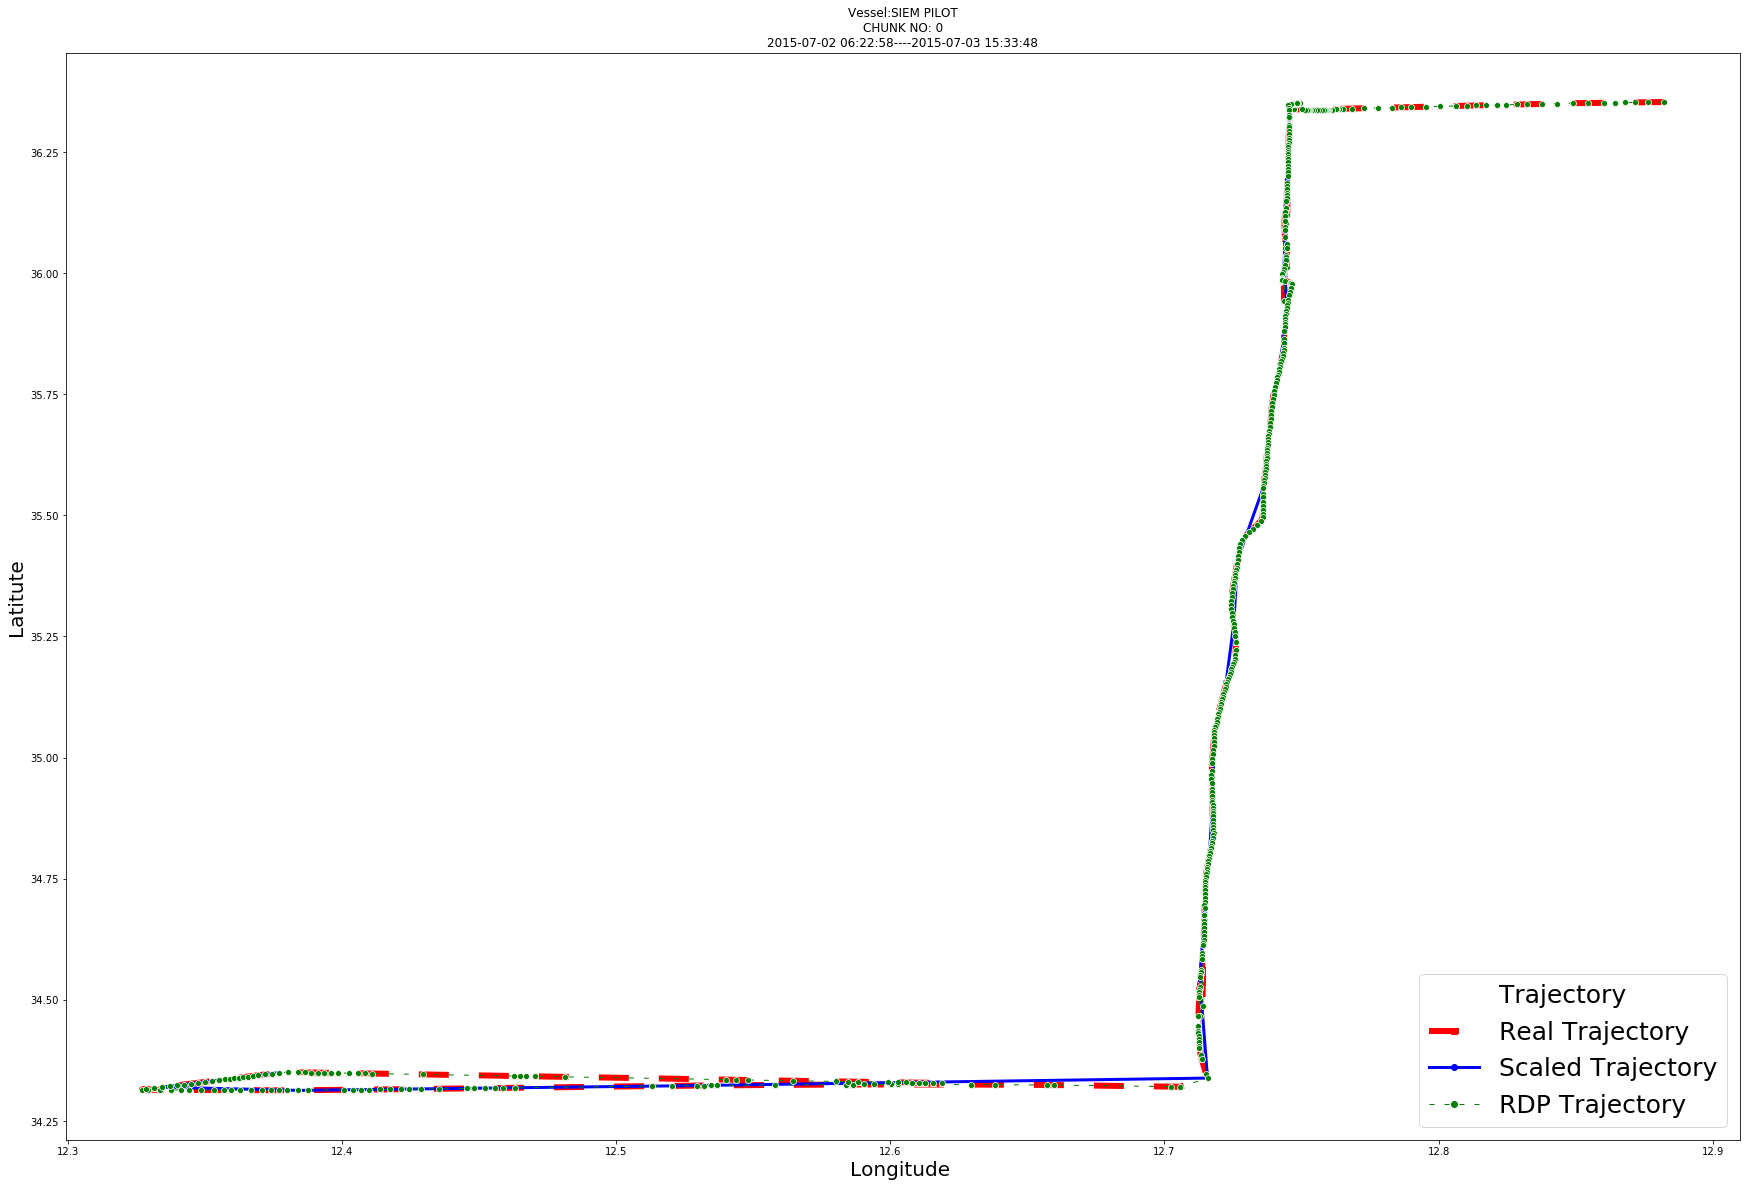

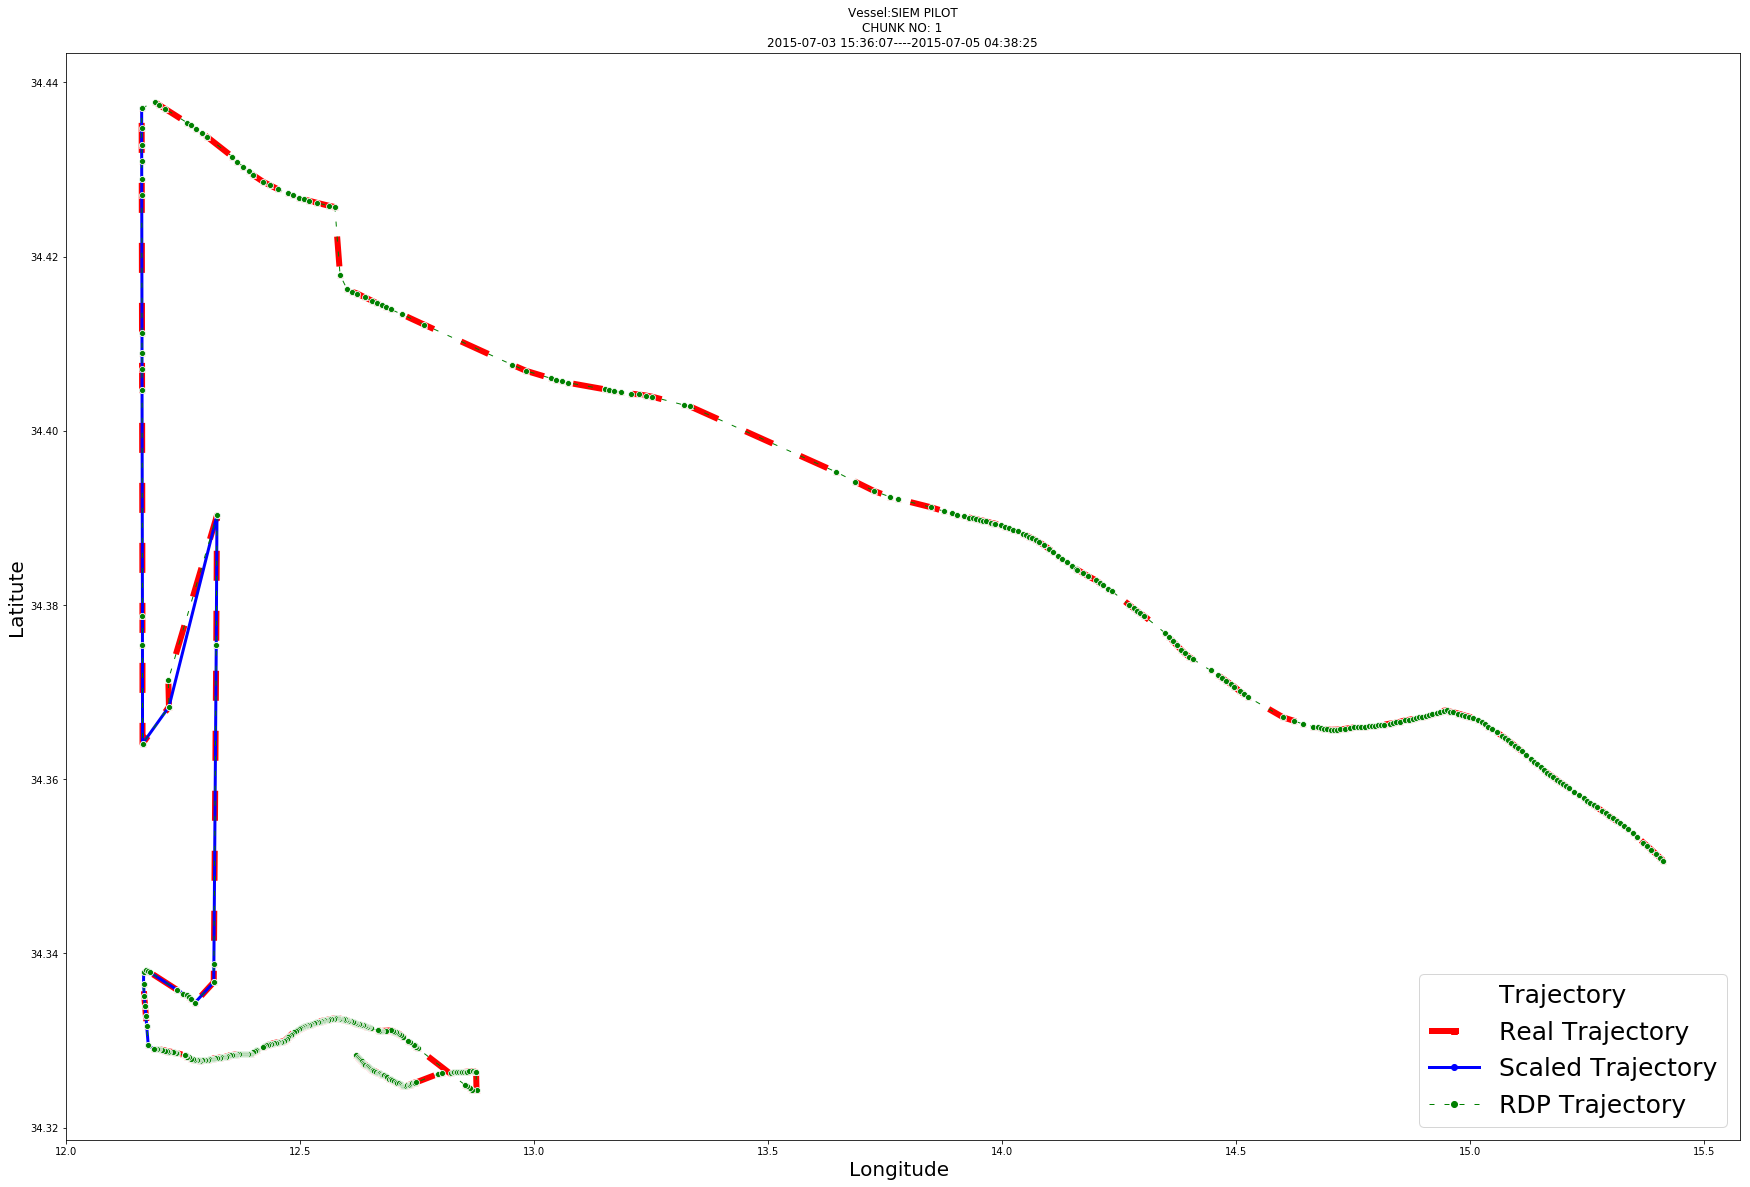

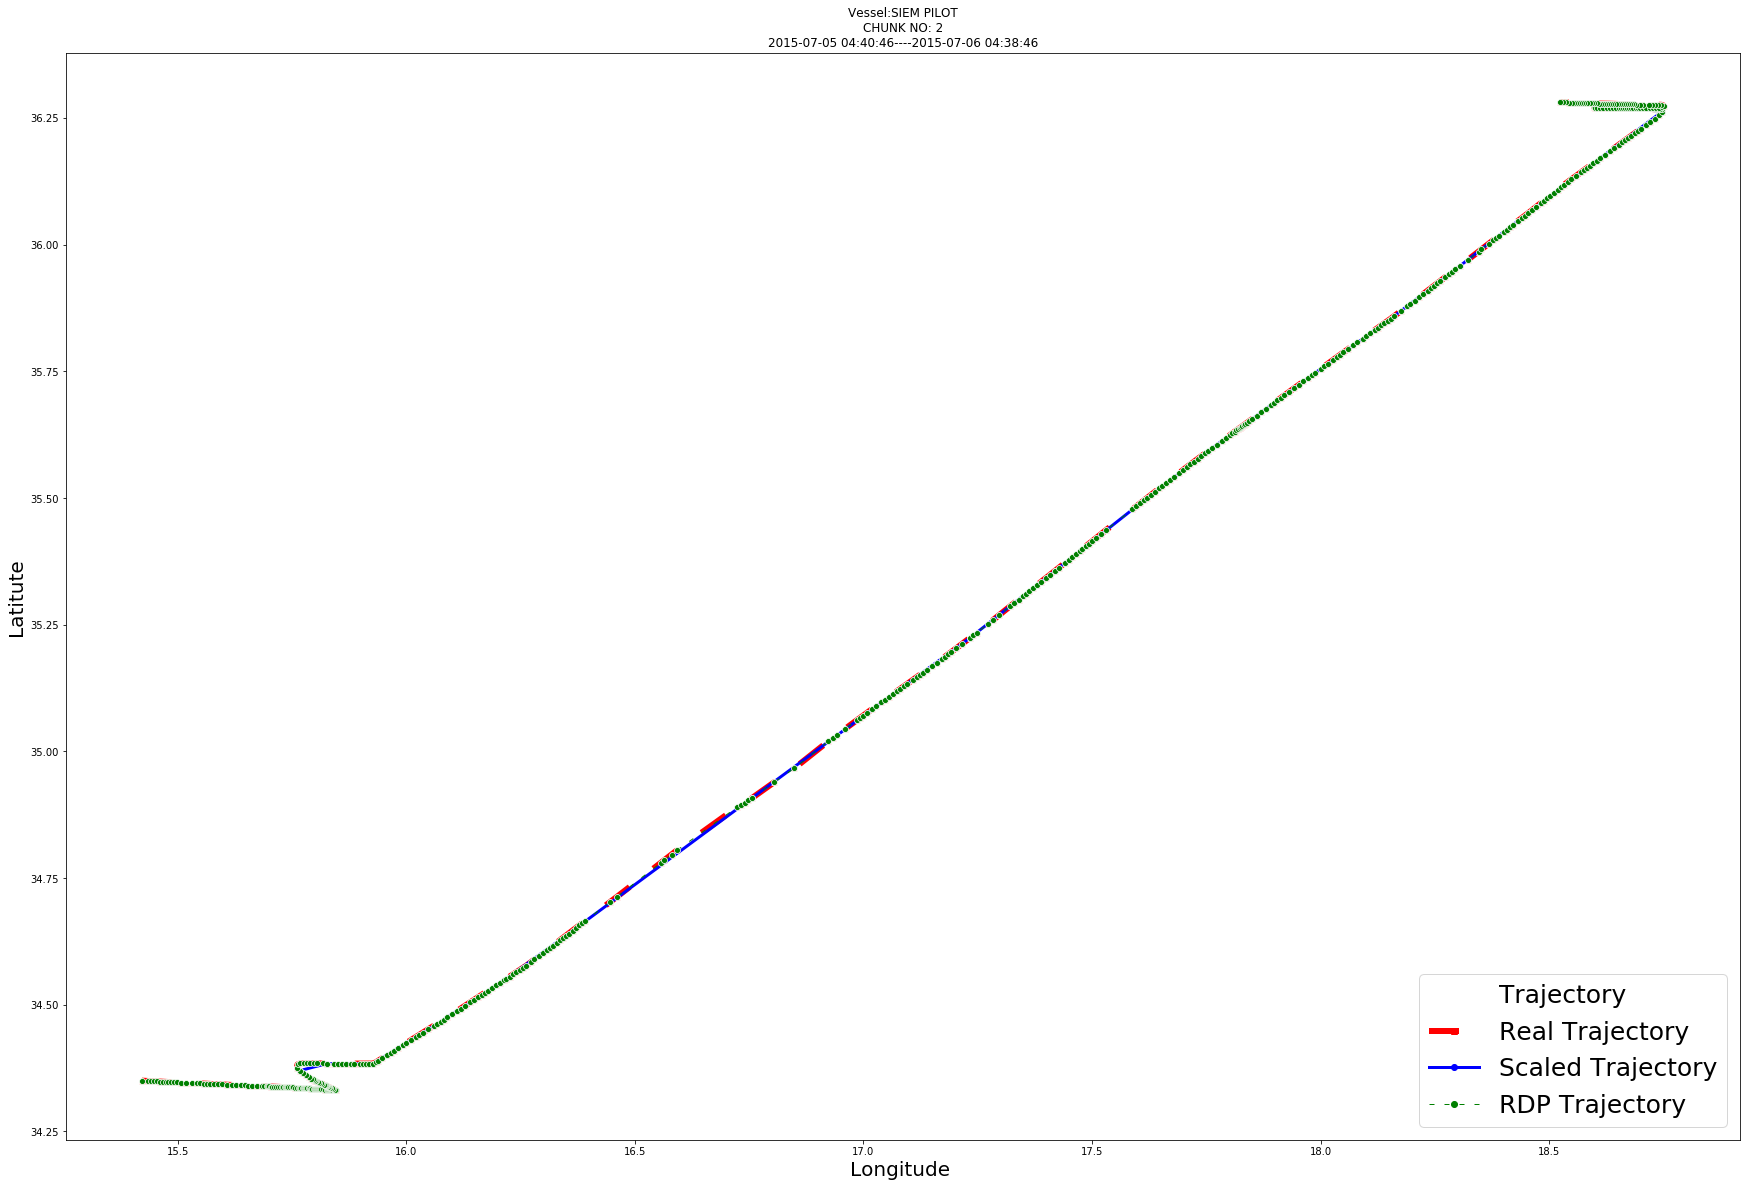

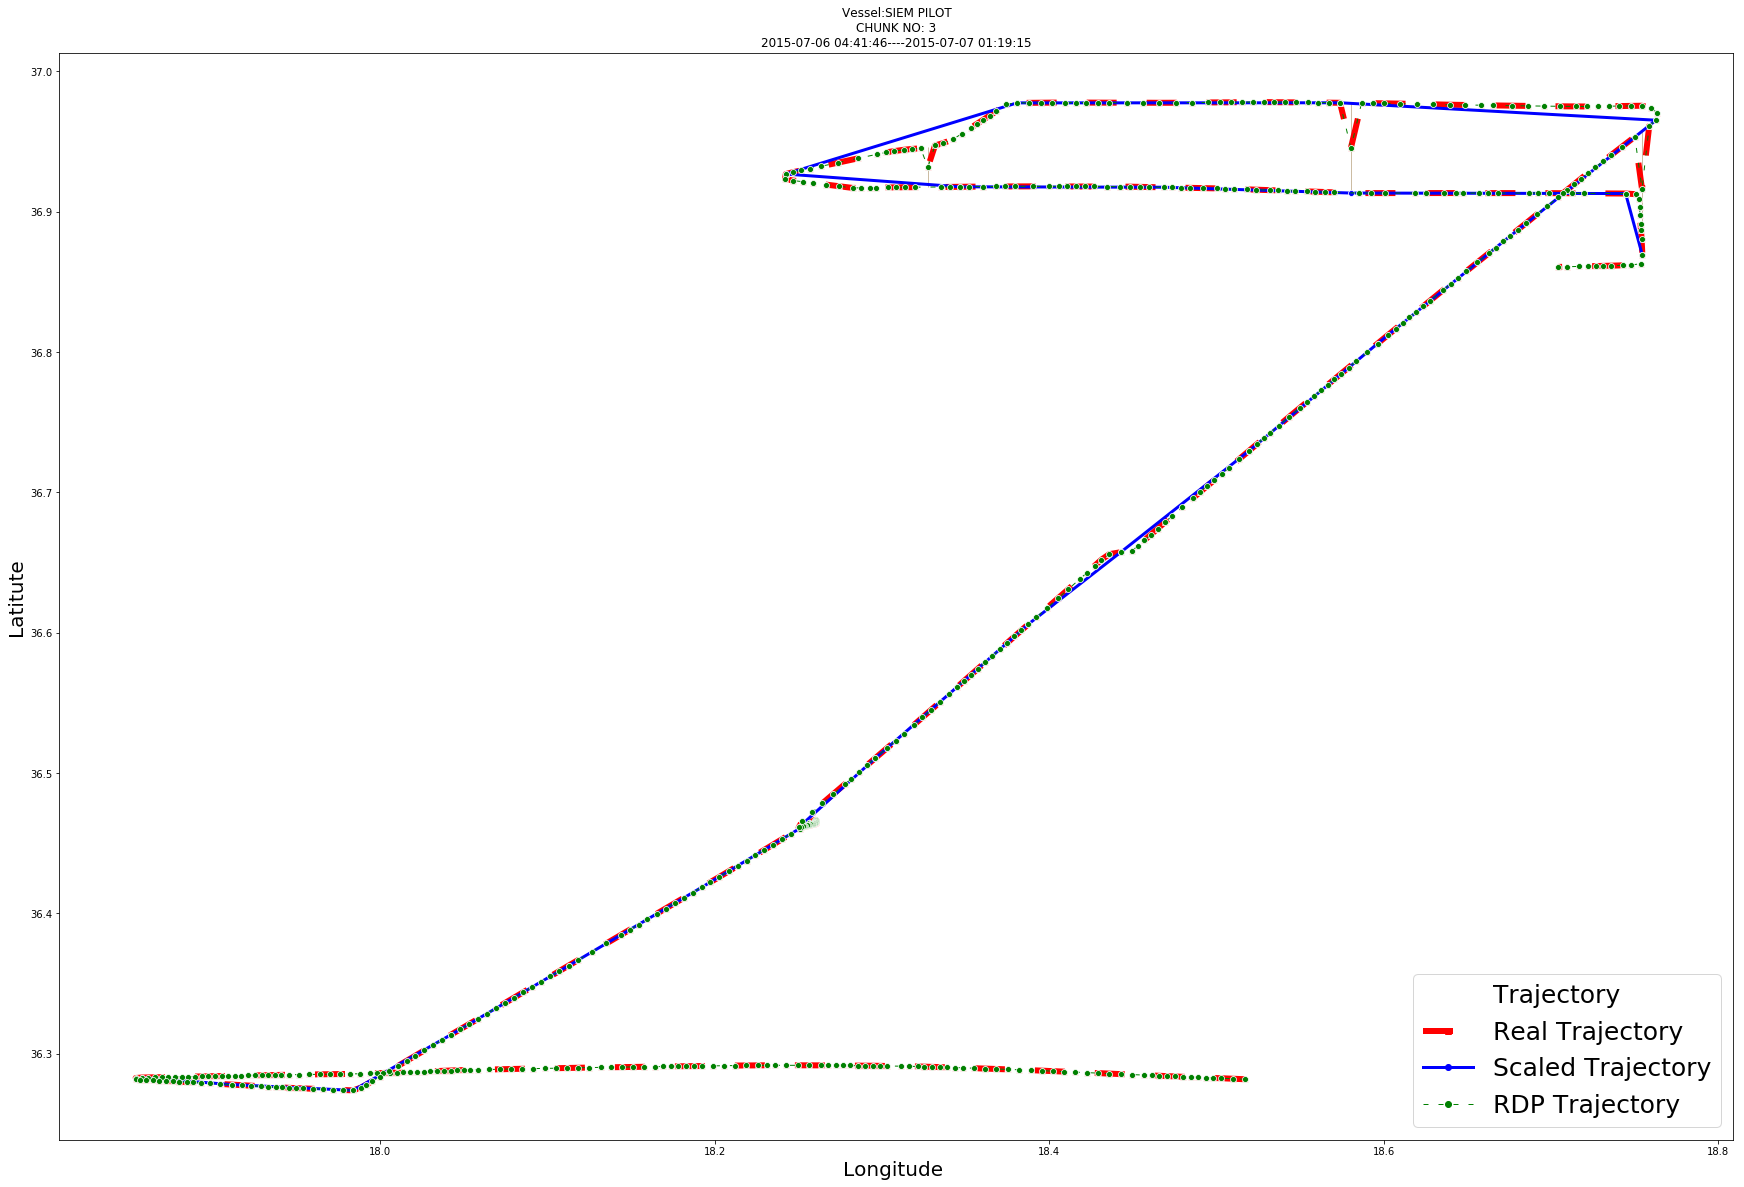

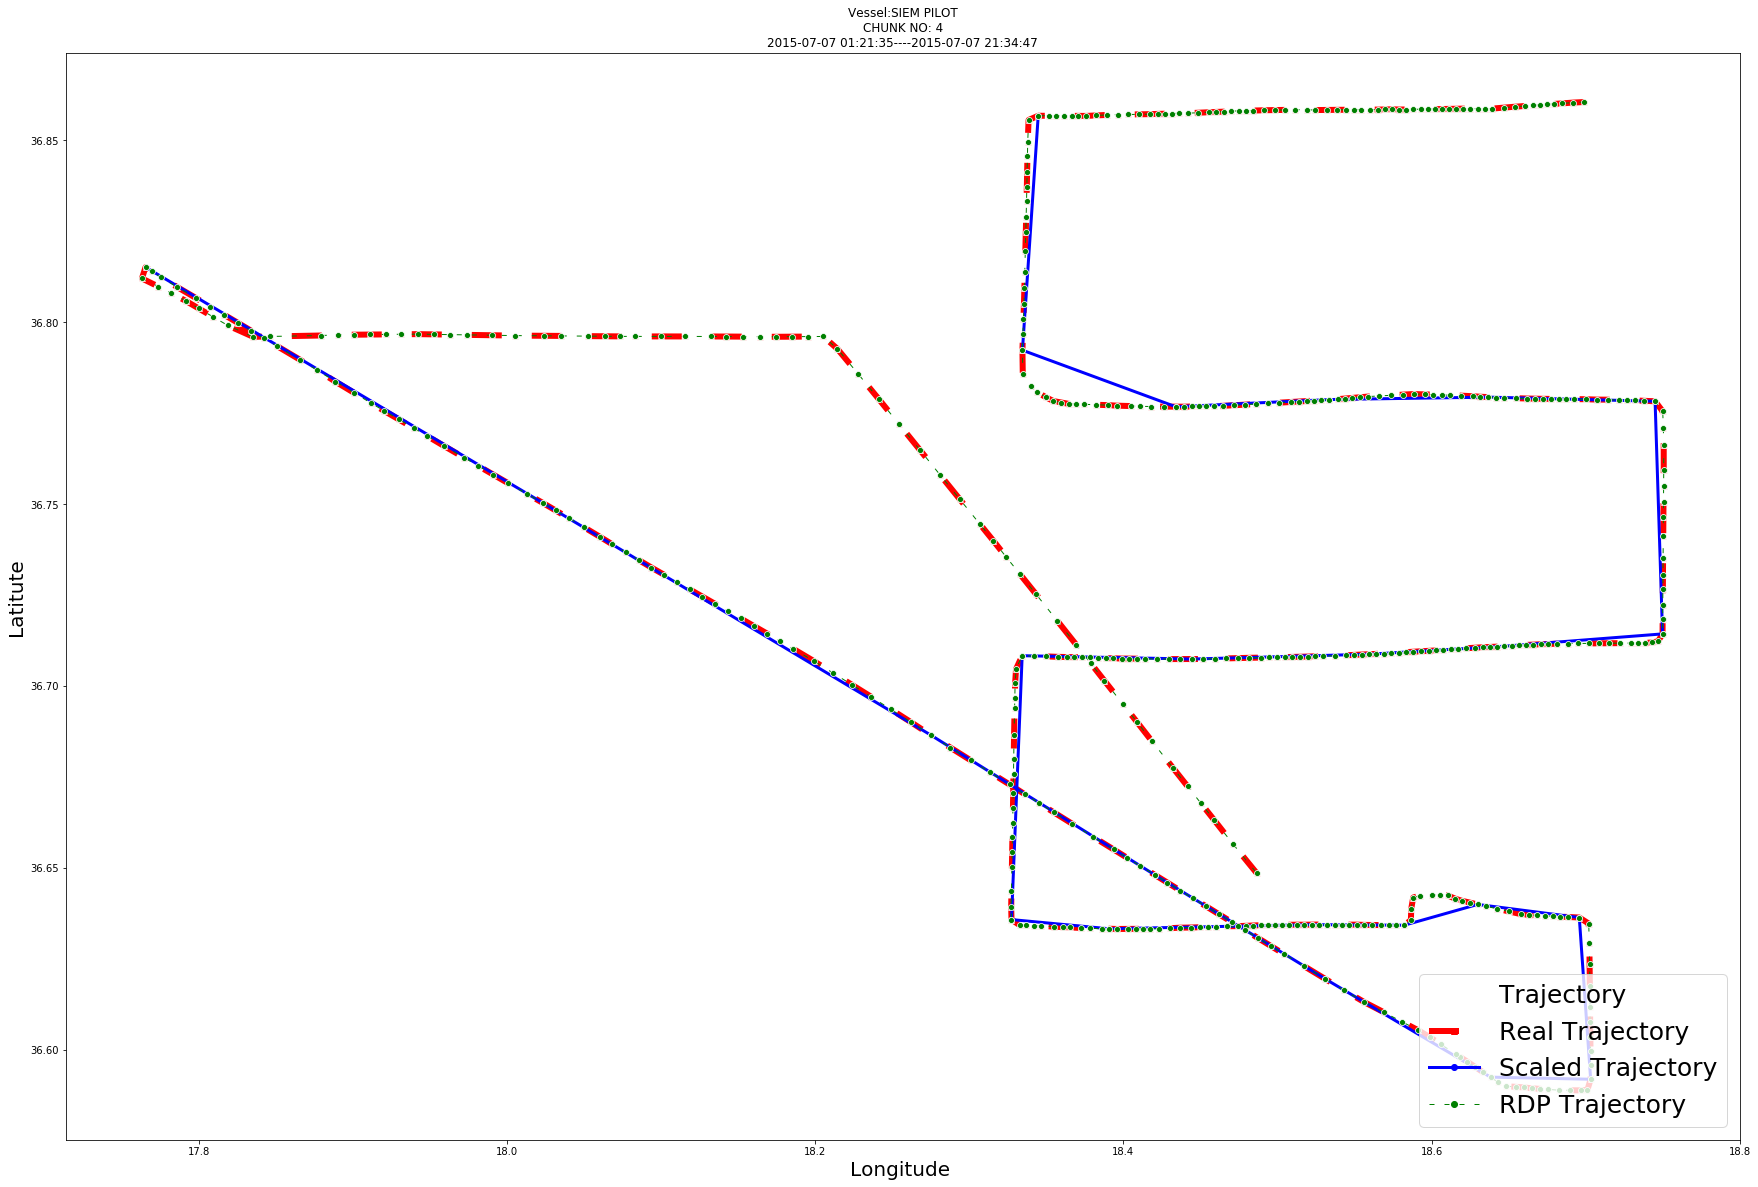

In [5]:
for idx,x in enumerate(ship["ship_dfs"]):
    lat = np.array(x["LAT"])
    lon = np.array(x["LON"])
    np_real_data = [np.array([x_lat,lon[idx]]) for idx,x_lat in enumerate(lat)]
    mask = rdp(np_real_data,algo="iter", return_mask=True,epsilon=0.5)
    rdp_data =  x[mask]
    plot_trajectory(x,train_test_options["split"],idx,ship["shipname"],rdp_data=rdp_data)